In [2]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

In [3]:
sys.path.append(r'C:\Users\lesliec\code')

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict, qualitycheck_trials, find_nearest_ind
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [5]:
%matplotlib notebook

#### Load excel sheet with metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load subject

In [7]:
# data_loc = r"F:\psi_exp\mouse666194\pilot_aw_2023-02-22_12-32-58\experiment1\recording1" # DAY1
# data_loc = r"F:\psi_exp\mouse666194\pilot_aw_psi_2023-02-23_10-40-34\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse669118\pilot_aw_2023-03-23_12-14-39\experiment1\recording1" # DAY1
# data_loc = r"F:\psi_exp\mouse669118\pilot_aw_psi_2023-03-24_09-55-33\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse669117\pilot_aw_2023-03-29_11-09-15\experiment1\recording1" # DAY1
# data_loc = r"F:\psi_exp\mouse669117\pilot_aw_psi_2023-03-30_11-37-07\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse689242\aw_psi_2023-07-19_10-29-49\experiment1\recording1" # DAY1
# data_loc = r"F:\psi_exp\mouse689242\aw_iso_2023-07-20_10-52-57\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse724057\aw_sal_2024-04-03_10-32-05\experiment1\recording1" # DAY1
data_loc = r"F:\psi_exp\mouse724057\aw_psi_2024-04-04_10-35-18\experiment1\recording1" # DAY2

In [8]:
exp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print('{} - {}'.format(exp.mouse, exp_tag))

Experiment type: electrical stimulation
724057 - aw_psi


In [9]:
## Grab exp metadata from Templeton-log_exp ##
exp_meta = metadata[(
    (metadata['mouse_name'].str.contains(exp.mouse)) &
    (metadata['exp_name'].str.contains(data_loc[data_loc.find('mouse')+12:data_loc.find('experiment1')-4]))
)].squeeze()
## Get bad EEG channels ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
print(bad_chs)
## Get injection times ##
try:
    inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
    print(inj_times)
except:
    inj_times = None

[0, 1, 4, 6, 13, 29]
[2568.0, 3347.0]


Load stim log

In [10]:
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good,mean_speed,resting_trial
0,biphasic,20,0.0004,794.83485,794.83525,0,True,0.0,True
1,biphasic,20,0.0004,801.42080,801.42120,0,True,0.0,True
2,biphasic,30,0.0004,808.18372,808.18412,0,True,0.0,True
3,biphasic,10,0.0004,815.48518,815.48558,0,True,0.0,True
4,biphasic,10,0.0004,822.01484,822.01524,0,True,0.0,True


Load EEG all event traces

In [11]:
all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
good_chs = np.array([x for x in eeg_chs if x not in bad_chs])
print(len(good_chs))

24


Load and plot running and pupil

In [12]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

In [13]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
    # pupildf.head()

    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    eyeD = pupildf.Eye_Diameter.values

else:
    print('No local Pupileye*.csv file. Check server.')

<IPython.core.display.Javascript object>


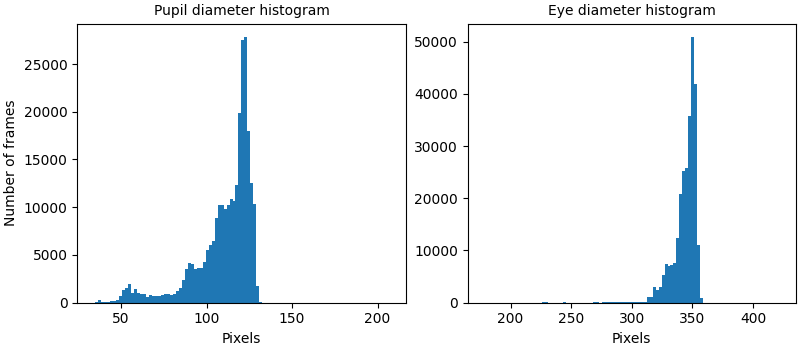

Text(0.5, 0, 'Pixels')

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8,3.5), constrained_layout=True)

axs[0].hist(pupilD, bins=100)
axs[0].set_title('Pupil diameter histogram')
axs[0].set_ylabel('Number of frames')
axs[0].set_xlabel('Pixels')

axs[1].hist(eyeD, bins=100)
axs[1].set_title('Eye diameter histogram')
axs[1].set_xlabel('Pixels')

## Smoothing the eye diameter

In [17]:
## Smooth eye diameter ##
smooth_eyeD = np.zeros_like(eyeD)
k = 50 # filter window is actually k*2+1
for i in range(k, len(eyeD)-k-1):
    smooth_eyeD[i] = np.mean(eyeD[i-k:i+k]) # each point is the average of k surrounding points
smooth_eyeD[:k] = eyeD[:k]
smooth_eyeD[-k-1:] = eyeD[-k-1:]

<IPython.core.display.Javascript object>


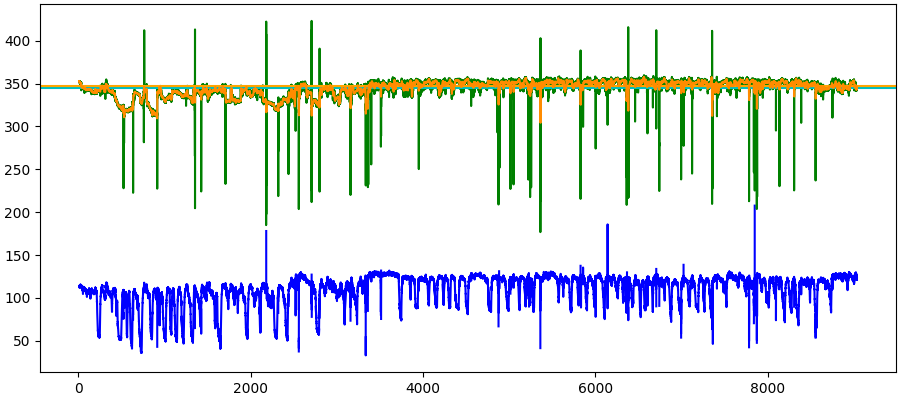

In [19]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

ax.plot(pupilts, pupilD, 'b')
ax.plot(pupilts, eyeD, 'g')
ax.axhline(np.mean(eyeD), color='c')
ax.axhline(np.median(eyeD), color='orange')
ax.plot(pupilts, smooth_eyeD, 'darkorange')

## Testing different normalizations

In [22]:
## pupil diameter / smoothed eye diameter
normpupil1 = pupilD / smooth_eyeD

## pupil diameter / mean eye diameter
normpupil2 = pupilD / np.mean(eyeD)

## smooth pupil diameter, then normalize ##
smooth_pup = np.zeros_like(pupilD)
k = 15 # filter window is actually k*2+1
for i in range(k, len(pupilD)-k-1):
    smooth_pup[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
smooth_pup[:k] = pupilD[:k]
smooth_pup[-k-1:] = pupilD[-k-1:]
normpupil3 = smooth_pup / np.mean(eyeD)

<IPython.core.display.Javascript object>


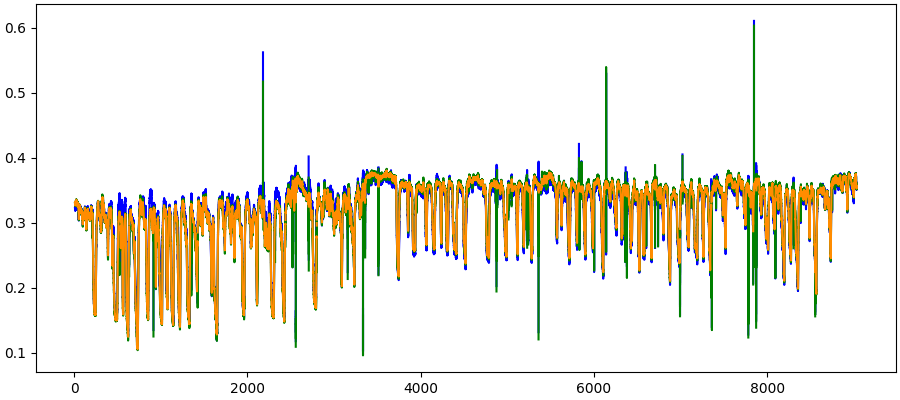

In [23]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

ax.plot(pupilts, normpupil1, 'b')
ax.plot(pupilts, normpupil2, 'g')
ax.plot(pupilts, normpupil3, 'darkorange')

<IPython.core.display.Javascript object>


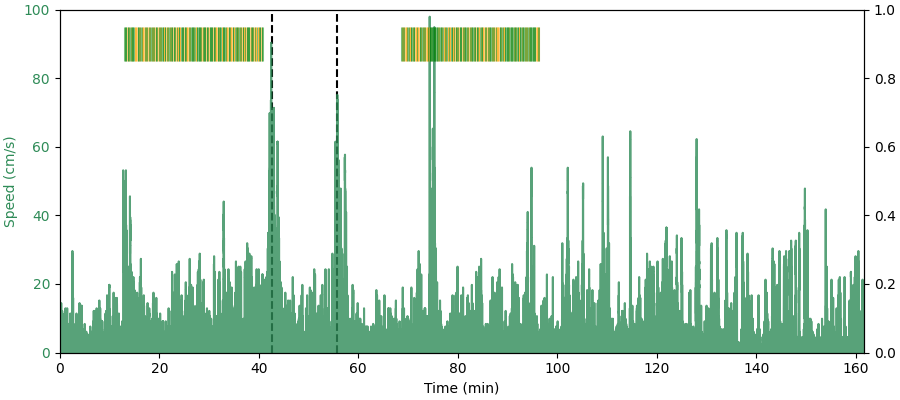

In [14]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

if inj_times is not None:
    for itime in inj_times:
        ax.axvline(itime/60, color='k', linestyle='dashed')

ax.plot(speedts/60, speed, 'seagreen', alpha=0.8)
ax.set_xlim([speedts[0]/60, speedts[-1]/60])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Speed (cm/s)', color='seagreen')
ax.tick_params(axis='y', labelcolor='seagreen')
ax.set_ylim([0, 100])

ax2 = ax.twinx()
if normpupil is not None:
    ax2.plot(pupilts/60, normpupil, 'm', alpha=0.8)
    ax2.set_ylabel('Normalized pupil diameter', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
ax2.set_ylim([0, 1])

## add stim times to plot ##
# for etype, ecol in zip(['biphasic', 'circle'], ['orange', 'blue']):
for rboo, rcol in zip([True, False], ['orange', 'green']):
    stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
    ax2.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)